In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_csv('TaxiData.csv')

# print(df['pickup_longitude'].isna().sum())
df['trip_seconds'] = df['trip_seconds'].fillna(0)

# df.sort_values(by='trip_miles')

## 4.a

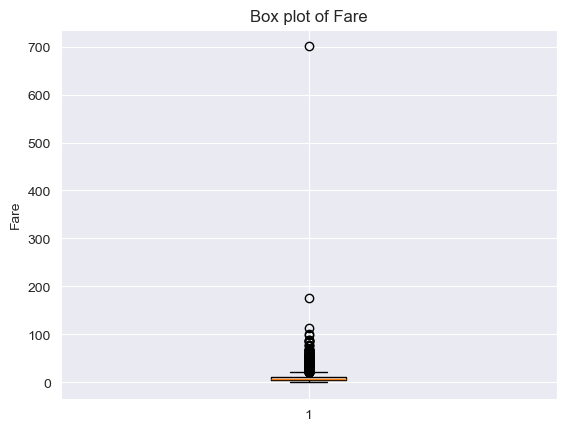

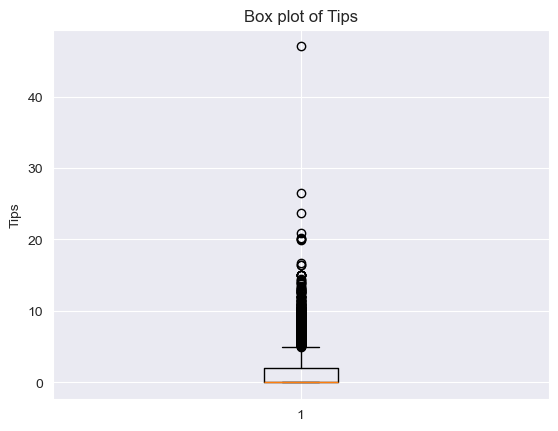

In [3]:
# Box plot for fare
plt.boxplot(df['fare'])
plt.title('Box plot of Fare')
plt.ylabel('Fare')
# plt.savefig('4a_1.png')
plt.show()
plt.close()

# Box plot for tips
plt.boxplot(df['tips'])
plt.title('Box plot of Tips')
plt.ylabel('Tips')
# plt.savefig('4a_2.png')
plt.show()
plt.close()


Here, outliers in both fare and tips greatly increase the average calculations due to their large magnitude.

For handling these outliers, we are going to remove them in the future using Z - scores.
A Z-score (or standard score) measures how many standard deviations a data point is from the mean of its distribution. It helps identify how unusual or "outlier-like" a value is in a dataset.

Here’s the formula for the Z-score of a value x:
$Z = \dfrac{x - \mu}{\sigma}$

$\mu$ = mean and $\sigma$ = standard deviation.

In [4]:
from scipy import stats

def remove_outliers_zscore(dataframe, threshold=3):
    # Calculate Z-scores
    z_scores = np.abs(stats.zscore(dataframe))
    # Apply the threshold to each row
    mask = (z_scores < threshold).all(axis=1)
    dataframe = dataframe[mask]
    
    return dataframe

## 4.b

In [5]:
# The first two rows of `df` have null entries of latitude and longitude
# For the regression, these two entries are removed
df_main = df[['trip_seconds', 'trip_miles', 'pickup_latitude', 'pickup_longitude', 'fare']].tail(-2)
df_main.head()

trip_seconds  trip_miles  pickup_latitude  pickup_longitude   fare
2        1380.0        12.6        41.836150        -87.648788  27.05
3         180.0         0.0        41.985015        -87.804532   5.85
4        1080.0         0.0        41.968069        -87.721559  16.65
5         780.0         6.9        41.983636        -87.723583  16.45
6        1200.0        15.4        41.953582        -87.723452  32.05

In [6]:
from sklearn.decomposition import PCA

# Select the columns for PCA
coords = df_main[['pickup_latitude', 'pickup_longitude']]

# Apply PCA
pca = PCA(n_components=1)
coords_pca = pca.fit_transform(coords)

# Add the PCA result back to the dataframe
df_main['coords_pca'] = coords_pca

df_main.head()

trip_seconds  trip_miles  pickup_latitude  pickup_longitude   fare  \
2        1380.0        12.6        41.836150        -87.648788  27.05   
3         180.0         0.0        41.985015        -87.804532   5.85   
4        1080.0         0.0        41.968069        -87.721559  16.65   
5         780.0         6.9        41.983636        -87.723583  16.45   
6        1200.0        15.4        41.953582        -87.723452  32.05   

   coords_pca  
2   -0.031304  
3    0.166235  
4    0.082510  
5    0.089781  
6    0.079290

In [7]:
# Applying the Z-score threshold as 2.5 as that was the most suitable
df1_cleaned = remove_outliers_zscore(df_main, 2.5)

# Perform linear regression on the cleaned data
from sklearn import linear_model

features = ['trip_seconds', 'trip_miles', 'pickup_latitude', 'pickup_longitude']
target = 'fare'

x = df1_cleaned[features].values.reshape(-1, len(features))
y = df1_cleaned[target].values

linear_regression = linear_model.LinearRegression()
model = linear_regression.fit(x, y)
print(len(df_main), len(df1_cleaned), sep='\n')

15000
13416


In [8]:
from sklearn.metrics import mean_squared_error

print(f"RMSE = {np.sqrt(mean_squared_error(y, model.predict(x)))}")
print(f"R^2 = {model.score(x, y)}")

RMSE = 2.860523621106582
R^2 = 0.803965165417579


<Axes: >

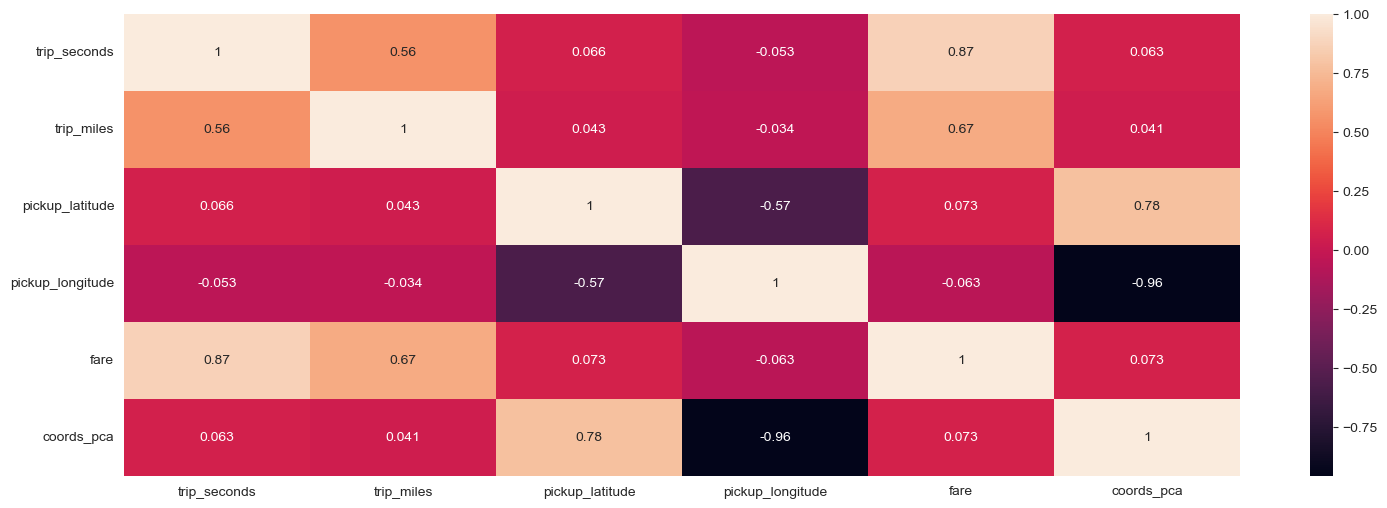

In [9]:
# Correlation Matrix for Testing Data
import seaborn as sns

fig, ax = plt.subplots(figsize=(18, 6))
sns.heatmap(df1_cleaned.corr(), annot=True)

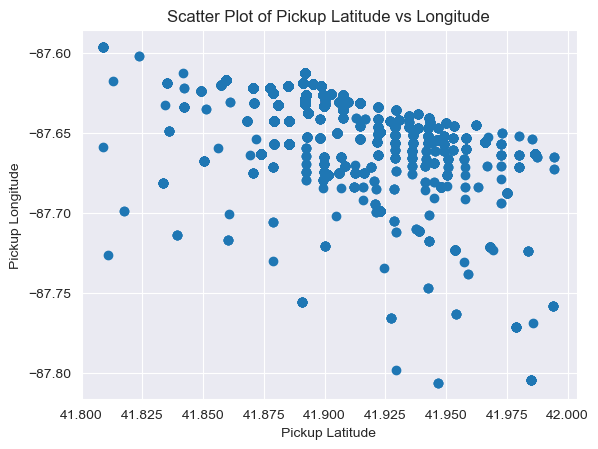

In [10]:
plt.scatter(df1_cleaned['pickup_latitude'], df1_cleaned['pickup_longitude'])
plt.xlabel('Pickup Latitude')
plt.ylabel('Pickup Longitude')
plt.title('Scatter Plot of Pickup Latitude vs Longitude')
plt.show()
plt.close()

I am using multivariate linear regression on the cleaned dataset (cleaned $\equiv$ removing the outliers). This model has $RMSE = 2.860523621106582$ and $R^2 = 0.803965165417579$. This model is ignoring the outliers such as long distances and more travel time. This model is good in calculating at the values nearer to the representative dataset, but not effective in calculating for huge variations.

The model can be improved by using better nonlinear regression models, along with considering the outliers which have a huge change in more than one parameter, as large deviations in one would have caused the other.